In [104]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.misc import imread
import scipy.stats
import imread



In [12]:
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2
def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

In [13]:
# MxN are Image dimensions 
# i and j is co-ordiantes of node being evaluated
# n is nearest neighbours
def neighbours(i,j,M,N,size=8):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        if (i==0 and j==0):
            n=[(0,1),(1,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2),(1,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1),(M-2,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2),(M-2,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j+1), (i+1,j-1)]
        return n
    return -1

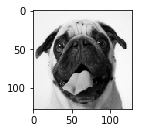

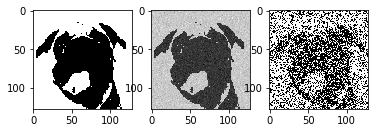

In [155]:
# proportion of pixels to alter

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def convertToBinary(im):
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if(im[i][j] >0.5):
                im[i][j] = 1
            else:
                im[i][j] = 0
    return im

prop = 0.7
prop2 = 0.3
varSigma = 0.1
# im = rgb2gray(imread('pug128x128.png'))
im = rgb2gray(imread.imread('pug128x128.png'))



im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im = convertToBinary(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im2 = add_gaussian_noise(im,prop,varSigma)
im2 = (im2 - im2.min())/(im2.max() - im2.min()) #normalising image
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')


im3 = add_saltnpeppar_noise(im,prop2)
im3 = (im3 - im3.min())/(im3.max() - im3.min())
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')

plt.show()

In [156]:
# Question 1
# Extra: extend noise (q1 extra)
# Iteratuve Conditional Modes
M, N = im2.shape

def prob(imX,  i, j, h, beta, eta):
    n = neighbours(i,j, M,N, size=8)
    sumPlus = 0 
    sumMinus = 0
    for k in range(np.shape(n)[0]):
        sumPlus += imX[n[k]] * 1
        sumMinus += imX[n[k]] * -1
    val1 = np.exp(-(h*1 - beta * sumPlus - eta*1*imX[i][j]))
    val2 = np.exp(-(h*-1 - beta * sumMinus - eta*-1*imX[i][j]))
    return val1>val2

def denoise_ICM(imX, h, beta, eta, iterations):
    x = imX.copy()
    for count in range(iterations):
        countChange = 0
        for i in  range(imX.shape[0]):
            for j in range(imX.shape[1]):
                if(prob(imX,i,j,h,beta,eta)):
                    if(imX[i][j] != 1):
                        countChange += 1
                    x[i][j] = 1                  
                else:
                    if(imX[i][j] != -1):
                        countChange += 1
                    x[i][j] = -1
        if (countChange == 0): 
            print("Found minimum early: " + str(count))
            return x
        imX = x.copy()
    return x

def img_restoration_check(original_img,restored_img):
    cnt = 0
    no_of_pixels = original_img.size
    for i in  range(original_img.shape[0]):
        for j in range(original_img.shape[1]):

            if original_img[i][j] == restored_img[i][j]:
                cnt += 1                

    return (cnt)/(no_of_pixels)

Found minimum early: 1


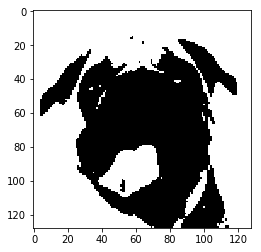

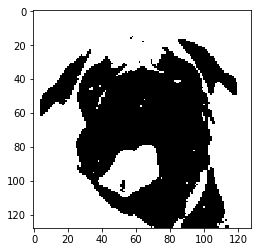

RESTORATION PERCENTAGE
0.99853515625


In [157]:
# imICM = denoise_ICM(im2, 0.1, 2, 0.7, 30)
# im2ICM = denoise_ICM(im2, 1, 0.3, 1.5, 30) # Imporoved performance
im2ICM = denoise_ICM(im2, 1, 0.1, 2, 60) # Parameters for 0.1 Var
im2ICM = (im2ICM + 1)/2


# im3ICM = denoise_ICM(im3, 0.7, 0.3, 3, 30)
imICM = (imICM + 1)/2
fig = plt.figure()

plt.imshow(im, cmap="gray")
plt.show()


plt.imshow(im2ICM, cmap="gray")
plt.show()

# plt.imshow(im3, cmap="gray")
# plt.show()

# plt.imshow(im3ICM, cmap="gray")
# plt.show()

# Numerical verification of image recovery
restoration_percent = img_restoration_check(im,im2ICM)
print("RESTORATION PERCENTAGE")
print(restoration_percent)


# test1 = im-im2ICM
# print(test1.max())
# print(test1.min())

# test2 = im2ICM-im
# print(test2.max())
# print(test1.min())

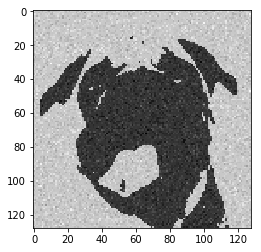

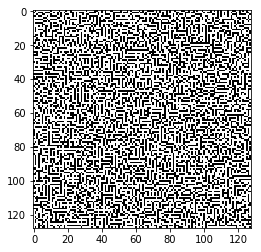

In [216]:
# Question 2
M, N = im2.shape

def prob_Gibbs(imX, i, j,beta):
    
    var = 1
    
    n = neighbours(i,j, M,N, size=8)

    
    sumPlus = 0 
    sumMinus = 0
    for k in n:        
        sumPlus += imX[k]*beta
    sumMinus = sumPlus * -1
        
# I think these are just used for ICM, with MCMC sampling we just look
# the neigbour values?
#     val1 = np.exp(-(h*1 - beta * sumPlus - eta*1*imX[i][j]))
#     val2 = np.exp(-(h*-1 - beta * sumMinus - eta*-1*imX[i][j]))
    val1 = np.exp(-(sumPlus))
    val2 = np.exp(-(sumMinus))
    prior_outcome = val1/(val1+val2)

    pos_prob = val1
    neg_prob = val2
    
#     pos_prob = scipy.stats.norm.pdf(imX[i][j],1,var)
#     neg_prob = scipy.stats.norm.pdf(imX[i][j],-1,var)
    
    pos_marginal_likelihood = pos_prob/(pos_prob+neg_prob)
    neg_marginal_likelihood = neg_prob/(pos_prob+neg_prob)
    numerator = np.exp(-(sumPlus+ (imX[i][j]*beta)))

    
    
    outcome = (numerator)/(pos_marginal_likelihood + neg_marginal_likelihood)
#     outcome = (prior_outcome*pos_marginal_likelihood)/(pos_marginal_likelihood + neg_marginal_likelihood)
#     outcome = (prior_outcome * pos_marginal_likelihood) / ((prior_outcome * pos_marginal_likelihood) + ((1 - prior_outcome) * (1 - pos_marginal_likelihood)))  
    
    p = np.random.uniform();
    return outcome>p

def denoise_Gibbs(imX,beta, iterations,random_order):
    x = imX.copy()
    for count in range(iterations):
        countChange = 0
        for i in  range(x.shape[0]):
            for j in range(x.shape[1]):
                if random_order == 1:
                    i = np.random.randint(x.shape[0]-1)
                    j = np.random.randint(x.shape[1]-1)
                
                if(prob_Gibbs(x,i,j,beta)):
                    x[i][j] = 1
                else:
                    x[i][j] = -1
    return x

fig = plt.figure()
im2Gibbs = denoise_Gibbs(im2, 0.5, 10,0)
#im3Gibbs = denoise_Gibbs(im3, 0.5, 0.8, 0.7, 10)


plt.imshow(im2,cmap='gray')
plt.show()

plt.imshow(im2Gibbs,cmap='gray')
plt.show()